In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch
cuda = torch.cuda.is_available()

try:
    from plotting_CIFAR10 import plot_autoencoder_stats
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

# Batch size is set to 4 
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


In [3]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 2

# Test data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([64, 3, 32, 32])
Number of distinct labels: 2


tensor([[[[-0.2549, -0.2392, -0.2157,  ..., -0.1451, -0.1608, -0.1843],
          [-0.2706, -0.2471, -0.2235,  ..., -0.1451, -0.1608, -0.1843],
          [-0.2627, -0.2392, -0.2157,  ..., -0.1373, -0.1451, -0.1686],
          ...,
          [-0.2000, -0.2078, -0.2078,  ..., -0.3804, -0.4588, -0.5451],
          [-0.1294, -0.1373, -0.1373,  ..., -0.0980, -0.1686, -0.2627],
          [-0.0667, -0.0745, -0.0745,  ..., -0.1059, -0.1137, -0.1294]],

         [[-0.6549, -0.6627, -0.6627,  ..., -0.6157, -0.6314, -0.6549],
          [-0.6627, -0.6627, -0.6627,  ..., -0.6157, -0.6314, -0.6549],
          [-0.6549, -0.6549, -0.6471,  ..., -0.6078, -0.6235, -0.6471],
          ...,
          [-0.7333, -0.7333, -0.7333,  ..., -0.7098, -0.7647, -0.8275],
          [-0.6549, -0.6627, -0.6627,  ..., -0.6000, -0.6471, -0.7176],
          [-0.5608, -0.5686, -0.5608,  ..., -0.6235, -0.6157, -0.6157]],

         [[ 0.3020,  0.3255,  0.3490,  ...,  0.4275,  0.3961,  0.3804],
          [ 0.2784,  0.3020,  

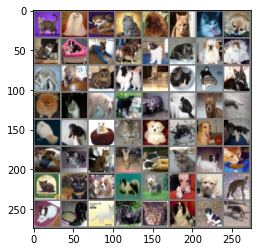

In [4]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(images)

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [6]:
# Image dimensions
channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_features = (height * width) * channels

# First convolution layer
num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 100
padding_conv1 = 2
input_dim = 32

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

conv_out_height = compute_conv_dim(height)
conv_out_width = compute_conv_dim(width)

print("num_filters_conv1 = ", num_filters_conv1)
print("conv_out_height = ", conv_out_height)
print("conv_out_width = ", conv_out_width)

# Encoder layer
h1e = 500

# Decoder layer
h1d = 400
h2d = 1000

class AutoEncoder(nn.Module):
    def __init__(self, latent_features=2):
        super(AutoEncoder, self).__init__()
        # We typically employ an "hourglass" structure
        # meaning that the decoder should be an encoder
        # in reverse.

        # Encoder
        #self.encoder = nn.Sequential(
        #    nn.Conv2d(in_channels=channels, 
        #              out_channels=num_filters_conv1,
        #              kernel_size=kernel_size_conv1, 
        #              stride=stride_conv1,
        #             padding=padding_conv1),
        #    nn.ReLU(),
        #    nn.Linear(in_features=num_filters_conv1*conv_out_height*conv_out_width, out_features=h1e),
        #    nn.ReLU(),
        #    # bottleneck layer
        #    nn.Linear(in_features=h1e, out_features=latent_features)
        #)
        
        self.conv_1 = Conv2d(in_channels=channels, 
                      out_channels=num_filters_conv1,
                      kernel_size=kernel_size_conv1, 
                      stride=stride_conv1,
                      padding=padding_conv1)
        
        self.l2_in_features = num_filters_conv1*conv_out_height*conv_out_width
        
        self.l_2 = Linear(in_features = self.l2_in_features,
                         out_features = h1e,
                         bias=True)
        
        self.l_out = Linear(in_features = h1e,
                           out_features = latent_features,
                           bias=False)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=h1d),
            nn.ReLU(),
            nn.Linear(in_features=h1d, out_features=h2d),
            nn.ReLU(),
            # output layer, projecting back to image size
            nn.Linear(in_features=h2d, out_features=num_features)
        )

    def forward(self, x): 
        outputs = {}
        # we don't apply an activation to the bottleneck layer

        #z = self.encoder(x)
        
        z = relu(self.conv_1(x))
        z = z.view(-1, self.l2_in_features)
        z = relu(self.l_2(z))
        z = relu(self.l_out(z))
        
        x_hat = torch.sigmoid(self.decoder(z))
        
        return {
            'z': z,
            'x_hat': x_hat
        }


# Choose the shape of the autoencoder
net = AutoEncoder(latent_features=100)

#if cuda:
#    net = net.cuda()

print(net)

num_filters_conv1 =  16
conv_out_height =  32
conv_out_width =  32
AutoEncoder(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (l_2): Linear(in_features=16384, out_features=500, bias=True)
  (l_out): Linear(in_features=500, out_features=100, bias=False)
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=3072, bias=True)
  )
)


In [7]:
import torch.optim as optim

# if you want L2 regularization, then add weight_decay to SGD
optimizer = optim.SGD(net.parameters(), lr=0.25)

# We will use pixel wise mean-squared error as our loss function
loss_function = nn.MSELoss()

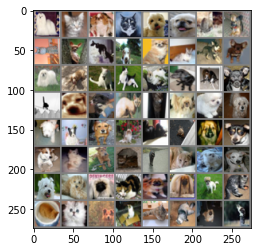

In [8]:
# test the forward pass
# expect output size of [32, num_features]
x, y = next(iter(trainloader))
imshow(torchvision.utils.make_grid(x))
#print(f"x.shape = {x.shape}")
#print(x)
#print(f"y.shape = {y.shape}")
#print(y)

In [9]:
#if cuda:
#    x = x.cuda()

outputs = net(x)
print(f"x.shape = {x.shape}")
print(f"x_hat.shape = {outputs['x_hat'].shape}")
print(type(x))
x_hat = outputs['x_hat']
print(type(x_hat))
mm = x.view(-1, width*height*channels)
print(f"mm.shape = {mm.shape}")

x.shape = torch.Size([64, 3, 32, 32])
x_hat.shape = torch.Size([64, 3072])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
mm.shape = torch.Size([64, 3072])


In [10]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

num_epochs = 2

train_loss = []
valid_loss = []
counter = 0
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in trainloader:
        
        #if cuda:
        #    x = x.cuda()
        
        outputs = net(x)
        x_hat = outputs['x_hat']

        #if counter == 2499:
        #    print("Hej")
        # note, target is the original tensor, as we're working with auto-encoders
        loss = loss_function(x_hat, x.view(-1, width*height*channels)) # TC: Changes this
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        counter = counter + 1
        #print("Counter", counter)

    train_loss.append(np.mean(batch_loss))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(testloader))
        
        #if cuda:
        #    x = x.cuda()
        
        outputs = net(x)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x_hat = outputs['x_hat']
        z = outputs['z'].cpu().numpy()

        loss = loss_function(x_hat, x.view(batch_size, width*height*channels))

        valid_loss.append(loss.item())
    
    if epoch == 0:
        continue

    print("Epoch", epoch, "/", num_epochs)
    # live plotting of the trainig curves and representation
    #imshow(torchvision.utils.make_grid(x))
    #plot_autoencoder_stats(x=x.view(batch_size, width*height*channels),
    #                       x_hat=x_hat,
    #                       z=z,
    #                       y=y,
    #                       train_loss=train_loss,
    #                       valid_loss=valid_loss,
    #                       epoch=epoch,
    #                       classes=classes,
    #                       dimensionality_reduction_op=None) # = lambda z: TSNE(n_components=2).fit_transform(z)


Epoch 1 / 2


In [12]:
print(x)
print(f"x.shape = {x.shape}")

tensor([[[[-0.7020, -0.5059,  0.1373,  ...,  0.1294,  0.2392, -0.0196],
          [-0.7020, -0.5686, -0.0118,  ...,  0.0510,  0.1922,  0.0588],
          [-0.6941, -0.6157, -0.2078,  ..., -0.0667,  0.1294,  0.1608],
          ...,
          [-0.5373, -0.5451, -0.4275,  ..., -0.6627, -0.8588, -0.7255],
          [-0.7412, -0.6392, -0.3961,  ..., -0.6392, -0.7412, -0.7569],
          [-0.7725, -0.6157, -0.4353,  ..., -0.7176, -0.7020, -0.8353]],

         [[-0.3647, -0.2157,  0.2863,  ...,  0.1137,  0.2863,  0.0824],
          [-0.3569, -0.2706,  0.1686,  ...,  0.0196,  0.2471,  0.1843],
          [-0.3569, -0.3020,  0.0039,  ..., -0.1294,  0.1608,  0.2706],
          ...,
          [-0.2941, -0.2706, -0.1294,  ..., -0.3725, -0.5686, -0.4431],
          [-0.5059, -0.3804, -0.1137,  ..., -0.3490, -0.4588, -0.4902],
          [-0.5608, -0.3804, -0.1765,  ..., -0.4431, -0.4431, -0.6000]],

         [[-0.9373, -0.6941,  0.1294,  ...,  0.0118,  0.2392, -0.0118],
          [-0.9529, -0.7725, -

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.99215686 ...  0.64705884  0.
    0.        ]
  ...
  [ 0.          0.          0.5294118  ... -0.44313723  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.         -0.8901961  ...  0.60784316  0.
    0.        ]
  ...
  [ 0.          0.          0.427451   ... -0.36470586  0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.   

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

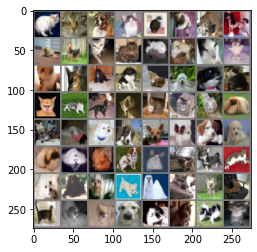

In [8]:
imshow(torchvision.utils.make_grid(x))
g = torchvision.utils.make_grid(x)
print(g.numpy())
imshow(g.numpy())

tensor([[-0.7020, -0.5059,  0.1373,  ..., -0.8745, -0.8588, -0.9294],
        [ 0.1608,  0.2549,  0.1059,  ..., -0.0510, -0.1294, -0.0510],
        [-0.2000, -0.2078, -0.1608,  ...,  0.4118,  0.2706,  0.2000],
        ...,
        [ 0.0275,  0.0667,  0.0902,  ..., -0.0824, -0.0980, -0.1608],
        [-0.3725, -0.5137, -0.3882,  ..., -0.0588, -0.3804, -0.7255],
        [-0.3098, -0.8118, -0.8275,  ..., -0.7020, -0.6941, -0.6706]])
q.shape = torch.Size([64, 3072])


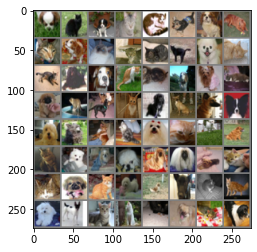

In [53]:
q = x.view(batch_size, width*height*channels)
print(q)
print(f"q.shape = {q.shape}")
m = imshow(torchvision.utils.make_grid(x))
m = torchvision.utils.make_grid(x)
m = m.permute(1,2,0)
m = m.numpy()
#plt.imshow(m,vmin=0,vmax=255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hej
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
tensor([[[[-0.7020, -0.5059,  0.1373,  ...,  0.1294,  0.2392, -0.0196],
          [-0.7020, -0.5686, -0.0118,  ...,  0.0510,  0.1922,  0.0588],
          [-0.6941, -0.6157, -0.2078,  ..., -0.0667,  0.1294,  0.1608],
          ...,
          [-0.5373, -0.5451, -0.4275,  ..., -0.6627, -0.8588, -0.7255],
          [-0.7412, -0.6392, -0.3961,  ..., -0.6392, -0.7412, -0.7569],
          [-0.7725, -0.6157, -0.4353,  ..., -0.7176, -0.7020, -0.8353]],

         [[-0.3647, -0.2157,  0.2863,  ...,  0.1137,  0.2863,  0.0824],
          [-0.3569, -0.2706,  0.1686,  ...,  0.0196,  0.2471,

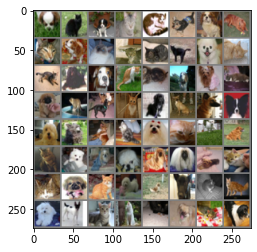

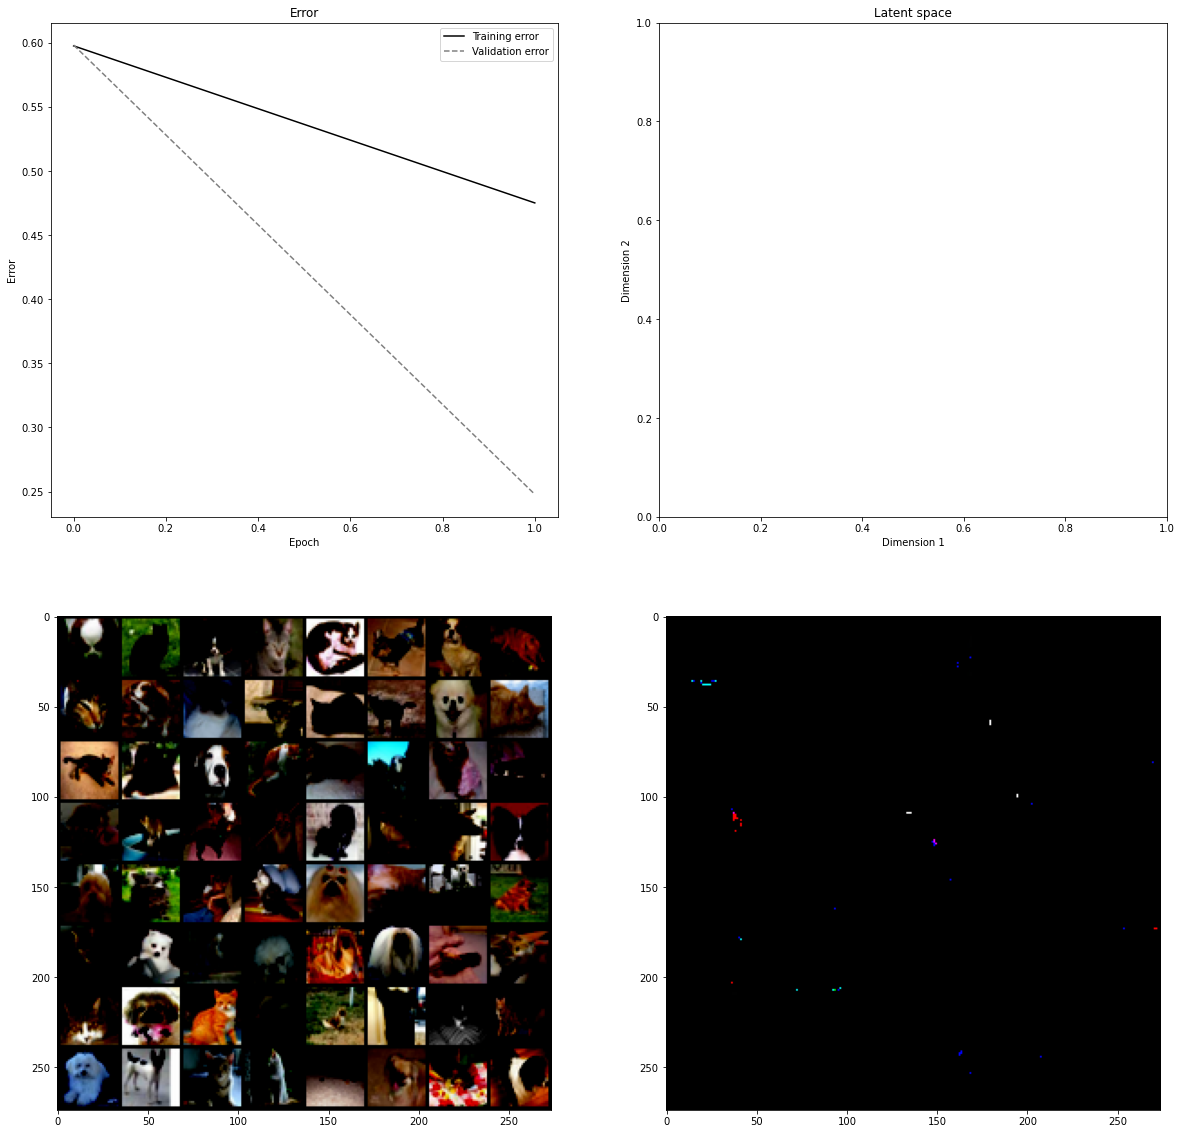

In [65]:
 # -- Plotting --
m = torchvision.utils.make_grid(x)
imshow(m)
f, axarr = plt.subplots(2, 2, figsize=(20, 20))

    # Loss
ax = axarr[0, 0]
ax.set_title("Error")
ax.set_xlabel('Epoch')
ax.set_ylabel('Error')

ax.plot(np.arange(epoch + 1), train_loss, color="black")
ax.plot(np.arange(epoch + 1), valid_loss, color="gray", linestyle="--")
ax.legend(['Training error', 'Validation error'])

    # Latent space
ax = axarr[0, 1]

ax.set_title('Latent space')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

    # If you want to use a dimensionality reduction method you can use
    # for example TSNE by projecting on two principal dimensions
    # TSNE.fit_transform(z)
#if dimensionality_reduction_op is not None:
#    z = dimensionality_reduction_op(z)

    #colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    #for c in classes:
    #    ax.scatter(*z[y.numpy() == c].T, c=next(colors), marker='o')

    #ax.legend(classes)

    # Inputs
#ax = axarr[1, 0]
#ax.set_title('Inputs')
#ax.axis('off')
#print(f"x.shape = {x.shape}")
#ax.plt.imshow(torchvision.utils.make_grid(x))
#axarr[1, 0].imshow(torchvision.utils.make_grid(x))
axarr[1, 0].imshow(m.permute(1,2,0))
axarr[1, 1].imshow(np.uint8(m.permute(1,2,0)))
hej = np.uint(m.permute(1,2,0))
print("Hej")
print(hej)
print(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


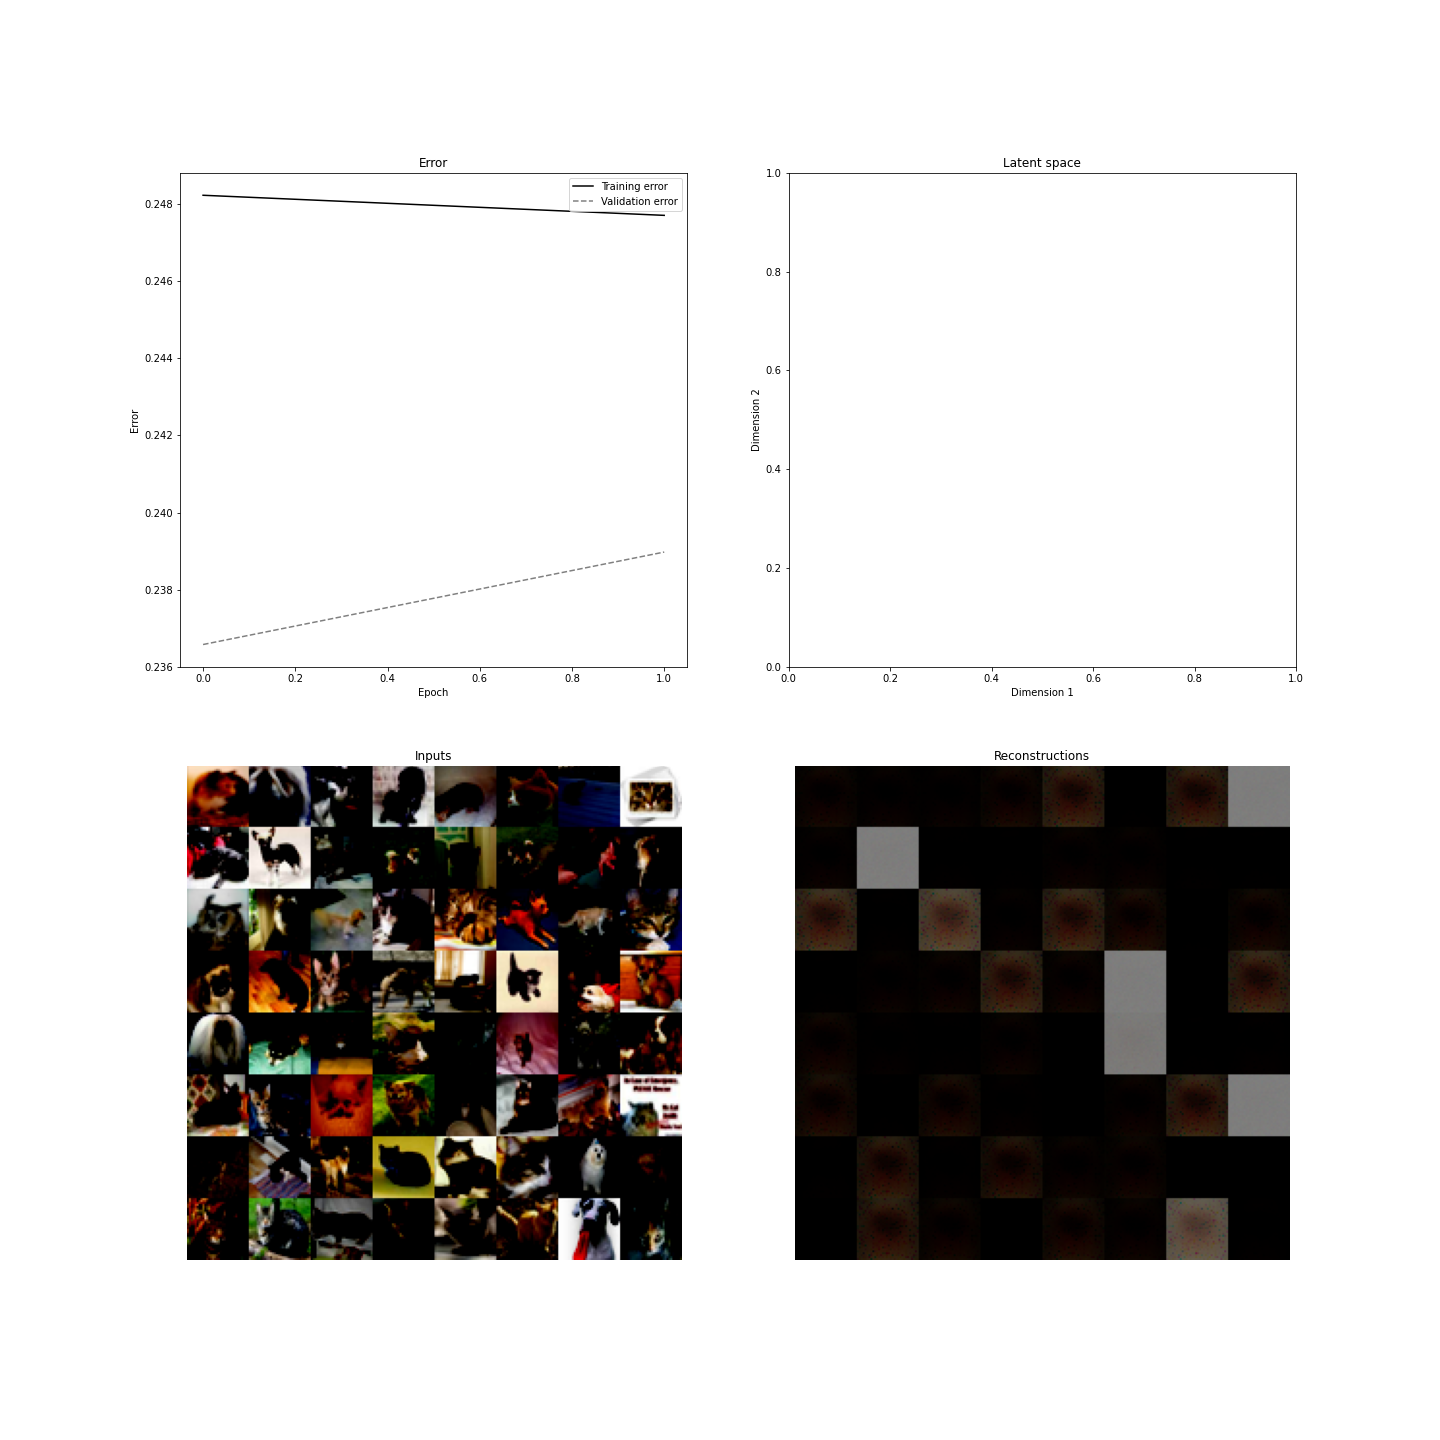

In [21]:
plot_autoencoder_stats(x=x.view(batch_size, width*height*channels),
                           x_hat=x_hat,
                           z=z,
                           y=y,
                           train_loss=train_loss,
                           valid_loss=valid_loss,
                           epoch=epoch,
                           classes=classes,
                           dimensionality_reduction_op=None) # = lambda z: TSNE(n_components=2).fit_transform(z)